In [25]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from collections import Counter
from sklearn.cluster import KMeans


# Path to your local image file
IMAGE_FILE = 'data/train/images/picture172.jpg'

# Display the image using OpenCV
img = cv2.imread(IMAGE_FILE)

In [2]:
# STEP 2: Create an ObjectDetector object with your custom model.
base_options = python.BaseOptions(model_asset_path='models/model.tflite')
options = vision.ObjectDetectorOptions(base_options=base_options,
                                       score_threshold=0.5)
detector = vision.ObjectDetector.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file(IMAGE_FILE)

# STEP 4: Detect objects in the input image.
detection_result = detector.detect(image)

I0000 00:00:1718701675.181926 9064203 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
/Users/leonpaletta/miniconda3/envs/cy/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


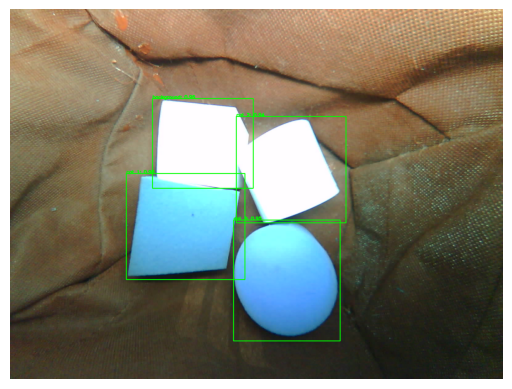

In [3]:
# STEP 5: Process the detection result. In this case, visualize it.
def visualize(image, detection_result):
    for detection in detection_result.detections:
        bbox = detection.bounding_box
        start_point = (int(bbox.origin_x), int(bbox.origin_y))
        end_point = (int(bbox.origin_x + bbox.width), int(bbox.origin_y + bbox.height))
        color = (0, 255, 0)  # Green color for the bounding box.
        thickness = 2
        image = cv2.rectangle(image, start_point, end_point, color, thickness)
        label = detection.categories[0].category_name
        confidence = detection.categories[0].score
        text = f"{label}: {confidence:.2f}"
        image = cv2.putText(image, text, start_point, cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    return image

image_copy = np.copy(image.numpy_view())
annotated_image = visualize(image_copy, detection_result)
rgb_annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

# Display the annotated image using matplotlib
plt.imshow(rgb_annotated_image)
plt.axis('off')
plt.show()

## For Video Inference

In [18]:
# Path to your local video file
VIDEO_FILE = 'data/videos/test1.mp4'
OUTPUT_VIDEO_FILE = 'data/videos/test1_annotated.mp4'
OUTPUT_CENTER_POINTS_FILE = 'data/videos/test1_center_points.txt'
OUTPUT_DOTS_VIDEO_FILE = 'data/videos/test1_center_points_video.mp4'
OUTPUT_BLOB_IMAGE = 'data/videos/test1_center_points_blob.png'


In [19]:
# STEP 2: Create an ObjectDetector object with your custom model.
base_options = python.BaseOptions(model_asset_path='models/model.tflite')
options = vision.ObjectDetectorOptions(base_options=base_options,
                                       score_threshold=0.5)
detector = vision.ObjectDetector.create_from_options(options)

# STEP 3: Define a function to visualize detection results on frames.
def visualize(image, detection_result, center_points_file, frame_idx):
    centers = []
    for detection in detection_result.detections:
        bbox = detection.bounding_box
        start_point = (int(bbox.origin_x), int(bbox.origin_y))
        end_point = (int(bbox.origin_x + bbox.width), int(bbox.origin_y + bbox.height))
        center_point = (int(bbox.origin_x + bbox.width / 2), int(bbox.origin_y + bbox.height / 2))
        centers.append((center_point, detection.categories[0].category_name))

        color = (0, 255, 0)  # Green color for the bounding box.
        thickness = 2
        image = cv2.rectangle(image, start_point, end_point, color, thickness)
        label = detection.categories[0].category_name
        confidence = detection.categories[0].score
        text = f"{label}: {confidence:.2f}"
        image = cv2.putText(image, text, start_point, cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    with open(center_points_file, 'a') as f:
        for center_point, label in centers:
            f.write(f"{frame_idx},{center_point[0]},{center_point[1]},{label}\n")

    return image

# Open the video file.
cap = cv2.VideoCapture(VIDEO_FILE)

# Get video properties.
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create a VideoWriter object to save the output video.
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(OUTPUT_VIDEO_FILE, fourcc, fps, (width, height))

# Create a VideoWriter object for the dots video.
dots_out = cv2.VideoWriter(OUTPUT_DOTS_VIDEO_FILE, fourcc, fps, (width, height))

frame_idx = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to a MediaPipe Image.
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)

    # Detect objects in the frame.
    detection_result = detector.detect(mp_image)

    # Annotate the frame.
    annotated_frame = visualize(frame, detection_result, OUTPUT_CENTER_POINTS_FILE, frame_idx)

    # Write the annotated frame to the output video.
    out.write(annotated_frame)

    # Create a white frame for the dots video.
    white_frame = np.ones_like(frame) * 255

    # Draw red dots for the center points on the white frame.
    for detection in detection_result.detections:
        bbox = detection.bounding_box
        center_point = (int(bbox.origin_x + bbox.width / 2), int(bbox.origin_y + bbox.height / 2))
        label = detection.categories[0].category_name
        white_frame = cv2.circle(white_frame, center_point, 10, (0, 0, 255), -1)
        white_frame = cv2.putText(white_frame, label, center_point, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    # Write the dots frame to the dots video.
    dots_out.write(white_frame)

    frame_idx += 1

    # Optionally, display the frame.
    # cv2.imshow('Annotated Frame', annotated_frame)
    # if cv2.waitKey(1) & 0xFF == ord('q'):
    #     break

# Release the video capture and writer objects.
cap.release()
out.release()
dots_out.release()
cv2.destroyAllWindows()

print(f'Annotated video saved as {OUTPUT_VIDEO_FILE}')
print(f'Center points saved as {OUTPUT_CENTER_POINTS_FILE}')
print(f'Center points video saved as {OUTPUT_DOTS_VIDEO_FILE}')

I0000 00:00:1718703801.578823 9064203 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1 Pro


Annotated video saved as data/videos/test1_annotated.mp4
Center points saved as data/videos/test1_center_points.txt
Center points video saved as data/videos/test1_center_points_video.mp4


# Create overview plot: 

In [ ]:
import cv2
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

def read_center_points(file_path):
    center_points = []
    labels = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            frame_idx, x, y, label = int(parts[0]), int(parts[1]), int(parts[2]), parts[3]
            center_points.append((x, y))
            labels.append(label)
    return center_points, labels

def compute_majority_label(labels):
    count = Counter(labels)
    majority_label = count.most_common(1)[0][0]
    return majority_label

def plot_center_points(center_points, labels, width, height):
    # Create a white frame for plotting
    white_frame = np.ones((height, width, 3), dtype=np.uint8) * 255
    
    # Calculate the mean center point
    mean_x = int(np.mean([p[0] for p in center_points]))
    mean_y = int(np.mean([p[1] for p in center_points]))
    
    # Determine the majority label
    majority_label = compute_majority_label(labels)
    
    # Draw the big blob at the mean center point
    white_frame = cv2.circle(white_frame, (mean_x, mean_y), 20, (0, 0, 255), -1)
    white_frame = cv2.putText(white_frame, majority_label, (mean_x + 30, mean_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    return white_frame

# Read the center points and labels from the file
center_points, labels = read_center_points(OUTPUT_CENTER_POINTS_FILE)

# Assuming width and height of the video frames
frame_width = 1920  # Update this to your video frame width
frame_height = 1080  # Update this to your video frame height

# Plot the center points and save the result as an image
blob_image = plot_center_points(center_points, labels, frame_width, frame_height)

# Save the result as an image file
cv2.imwrite(OUTPUT_BLOB_IMAGE, blob_image)

# Display the result using matplotlib
plt.imshow(cv2.cvtColor(blob_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

print(f'Center points blob image saved as {OUTPUT_BLOB_IMAGE}')


In [28]:
# Path to your local video file
VIDEO_FILE = 'data/videos/test1.mp4'
OUTPUT_VIDEO_FILE = 'data/videos/test1_annotated.mp4'
OUTPUT_CENTER_POINTS_FILE = 'data/videos/test1_center_points.txt'
OUTPUT_DOTS_VIDEO_FILE = 'data/videos/test1_center_points_video.mp4'
OUTPUT_BLOB_IMAGE = 'data/videos/test1_center_points_blob.png'
OUTPUT_DOTS_IMAGE ='data/videos/test1_dots.png'

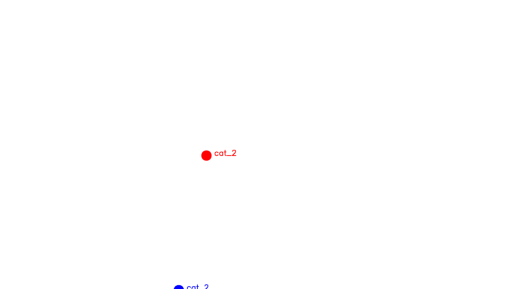

Center points blob image saved as center_points_blob.png


In [27]:
import cv2
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def read_center_points(file_path):
    center_points = []
    labels = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            frame_idx, x, y, label = int(parts[0]), int(parts[1]), int(parts[2]), parts[3]
            if label != "background":
                center_points.append((x, y))
                labels.append(label)
    return center_points, labels

def compute_majority_label(labels):
    count = Counter(labels)
    majority_label = count.most_common(1)[0][0]
    return majority_label

def plot_center_points(center_points, labels, width, height, n_clusters=3):
    # Create a white frame for plotting
    white_frame = np.ones((height, width, 3), dtype=np.uint8) * 255

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(center_points)
    cluster_centers = kmeans.cluster_centers_
    cluster_labels = kmeans.labels_

    # Determine the majority label for each cluster
    cluster_majority_labels = []
    for i in range(n_clusters):
        cluster_indices = [index for index, label in enumerate(cluster_labels) if label == i]
        cluster_labels_subset = [labels[index] for index in cluster_indices]
        majority_label = compute_majority_label(cluster_labels_subset)
        cluster_majority_labels.append(majority_label)

    # Draw blobs for each cluster center
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]  # Red, Green, Blue
    for i, center in enumerate(cluster_centers):
        center_x, center_y = int(center[0]), int(center[1])
        color = colors[i % len(colors)]
        white_frame = cv2.circle(white_frame, (center_x, center_y), 20, color, -1)
        white_frame = cv2.putText(white_frame, cluster_majority_labels[i], (center_x + 30, center_y), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

    return white_frame


# Read the center points and labels from the file
center_points, labels = read_center_points(OUTPUT_CENTER_POINTS_FILE)

# Assuming width and height of the video frames
frame_width = 1920  # Update this to your video frame width
frame_height = 1080  # Update this to your video frame height

# Plot the center points and save the result as an image
blob_image = plot_center_points(center_points, labels, frame_width, frame_height, n_clusters=3)

# Save the result as an image file
cv2.imwrite(OUTPUT_BLOB_IMAGE, blob_image)

# Display the result using matplotlib
plt.imshow(cv2.cvtColor(blob_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

print(f'Center points blob image saved as {OUTPUT_BLOB_IMAGE}')


/var/folders/c6/s_kk40g91zg5g_bf04nw0vcc0000gn/T/ipykernel_3591/789477371.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels)).colors


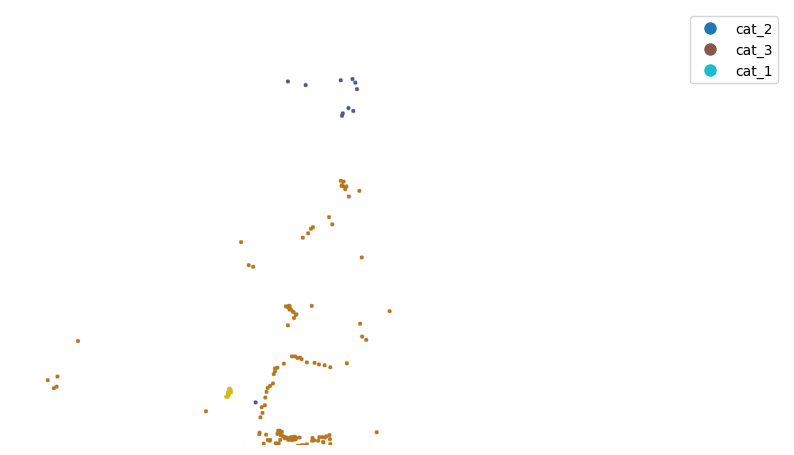

Center points dots image saved as data/videos/test1_dots.png


In [37]:
def read_center_points(file_path):
    center_points = []
    labels = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            frame_idx, x, y, label = int(parts[0]), int(parts[1]), int(parts[2]), parts[3]
            if label != "background":
                center_points.append((x, y))
                labels.append(label)
    return center_points, labels

def plot_all_center_points(center_points, labels, width, height):
    # Create a white frame for plotting
    white_frame = np.ones((height, width, 3), dtype=np.uint8) * 255

    # Define colors for each unique label
    unique_labels = list(set(labels))
    colors = plt.cm.get_cmap('tab10', len(unique_labels)).colors

    label_to_color = {label: (int(color[0]*255), int(color[1]*255), int(color[2]*255)) for label, color in zip(unique_labels, colors)}

    # Draw each center point with the corresponding color
    for (x, y), label in zip(center_points, labels):
        color = label_to_color[label]
        white_frame = cv2.circle(white_frame, (x, y), 5, color, -1)

    # Add legend to the plot
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color)/255, markersize=10, label=label) for label, color in label_to_color.items()]
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(white_frame, cv2.COLOR_BGR2RGB))
    plt.legend(handles=legend_elements, loc='upper right')
    plt.axis('off')
    plt.show()

    return white_frame

# Read the center points and labels from the file
center_points, labels = read_center_points(OUTPUT_CENTER_POINTS_FILE)

# Assuming width and height of the video frames
frame_width = 1920  # Update this to your video frame width
frame_height = 1080  # Update this to your video frame height

# Plot all center points and save the result as an image
dots_image = plot_all_center_points(center_points, labels, frame_width, frame_height)

# Save the result as an image file
cv2.imwrite(OUTPUT_DOTS_IMAGE, dots_image)

print(f'Center points dots image saved as {OUTPUT_DOTS_IMAGE}')